In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading the data

The dataset `creditcard.csv` is about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [2]:
import os

dataset_path = os.path.join('dataset', 'creditcard.csv')
df = pd.read_csv(dataset_path)

## Exploration

Since we directly use autoencoder to predict data, we need to remove some feautrue that have same desities both on normal data and fraud data.

In [3]:
print('origin shape:', df.shape)
df = df.drop(['V8', 'V13', 'V15', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27'], axis=1)
print('now shape', df.shape)

origin shape: (284807, 31)
now shape (284807, 21)


31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [4]:
df.isnull().values.any()

False

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [5]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

print('frauds shape:', frauds.shape)
print('normal shape:', normal.shape)

frauds shape: (492, 21)
normal shape: (284315, 21)


How different are the amount of money used in different transaction classes?

In [6]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [7]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Do fraudulent transactions occur more often during certain time?

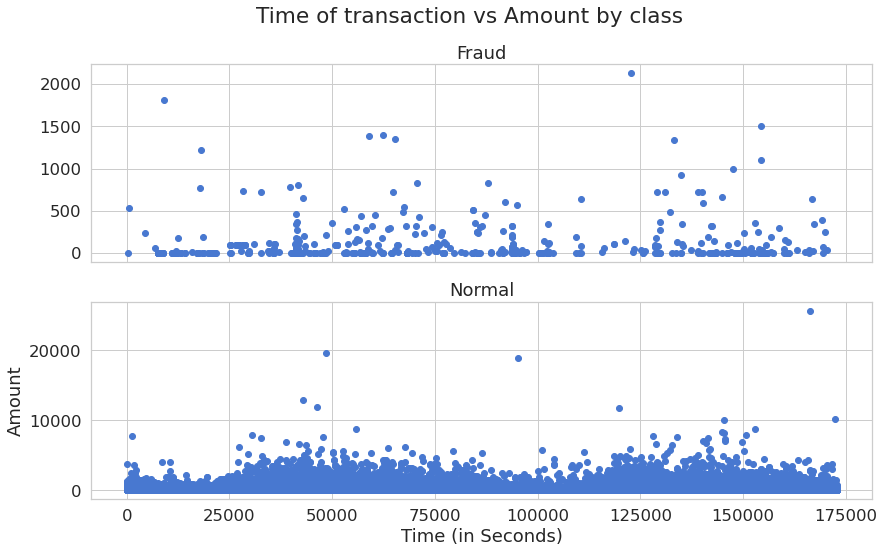

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [10]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [11]:
X_train.shape

(227451, 19)

# Building the model

Our Autoencoder uses 4 fully connected layers with 30, 10, 10 and 19 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [12]:
input_dim = X_train.shape[1]
encoding_dim = 30

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 3), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 3), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
 
autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [13]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
   1/7108 [..............................] - ETA: 2s - loss: 0.8991 - accuracy: 0.0312WARNING:tensorflow:From /usr/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
7108/7108 [==============================] - 20s 3ms/step - loss: 0.8734 - accuracy: 0.7120 - val_loss: 0.8464 - val_accuracy: 0.7810
Epoch 2/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7872 - accuracy: 0.7939 - val_loss: 0.8114 - val_accuracy: 0.8078
Epoch 3/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7644 - accuracy: 0.8190 - val_loss: 0.8032 - val_accuracy: 0.8308
Epoch 4/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7572 - accuracy: 0.8304 - val_loss: 0.8051 - val_accuracy: 0.8289
Epoch 5/100
7108/7108 [==============================] - 2

# Evaluation

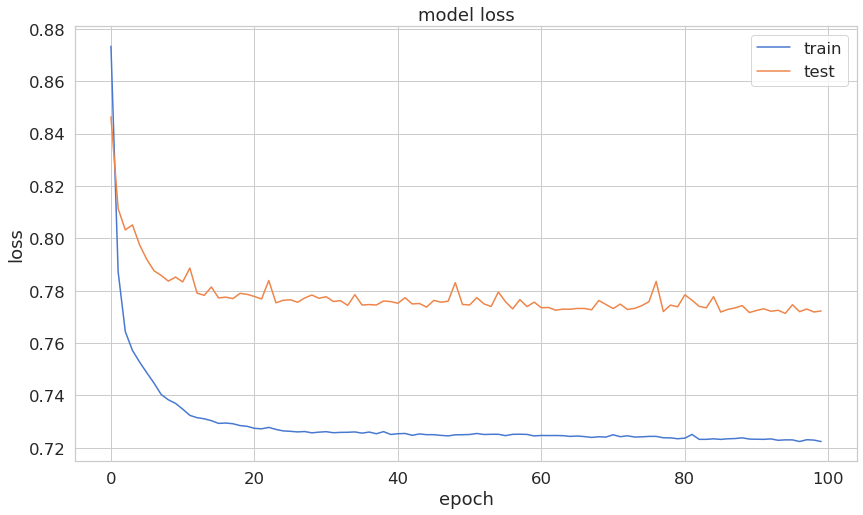

In [14]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [15]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [16]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.770213,0.001720
std,4.158726,0.041443
min,0.009805,0.000000
25%,0.198987,0.000000
50%,0.359737,0.000000
75%,0.641499,0.000000
max,298.715441,1.000000


## Reconstruction error without fraud

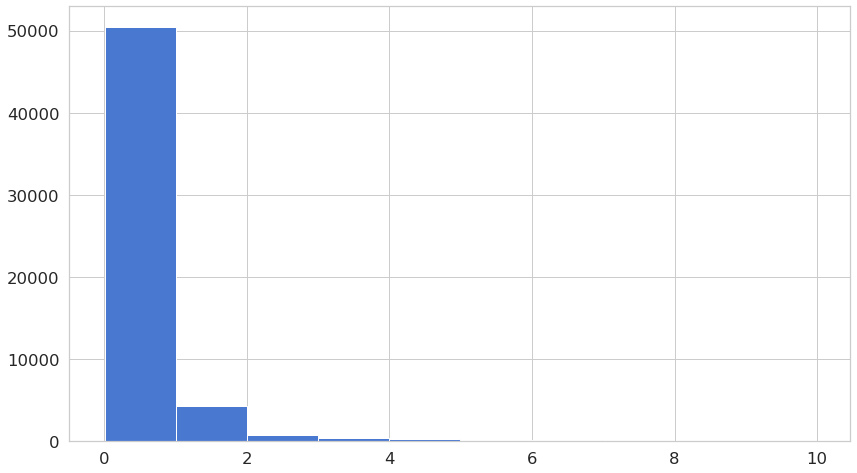

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

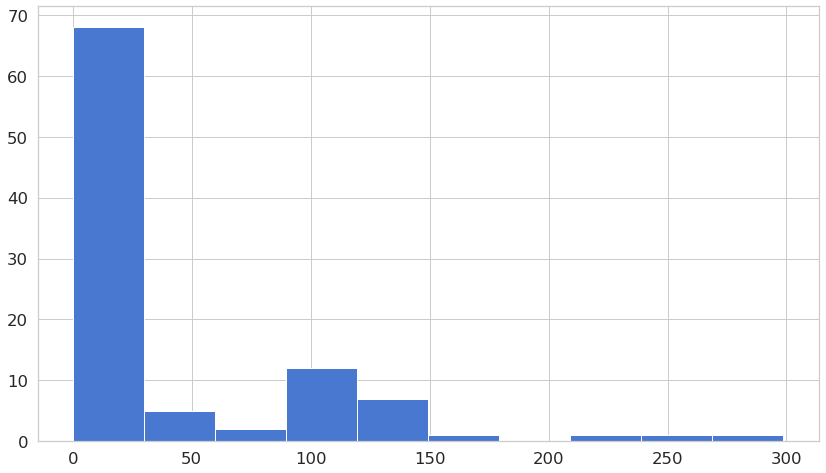

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [19]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

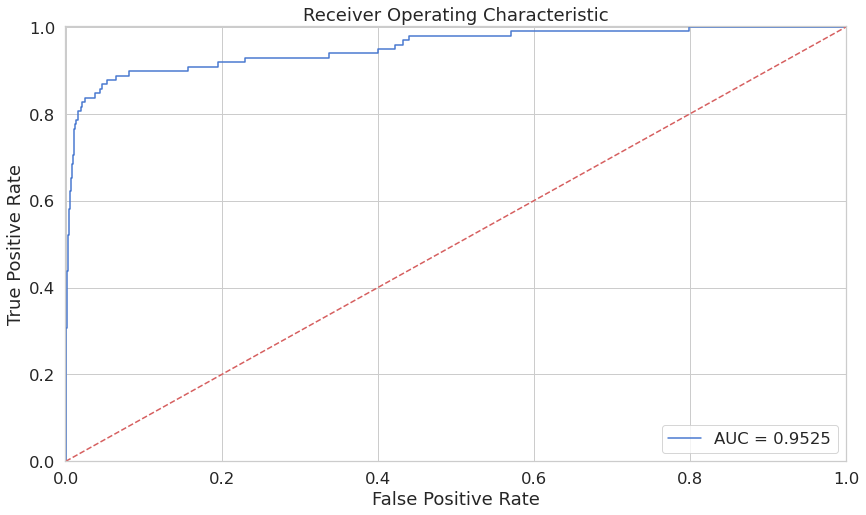

In [20]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

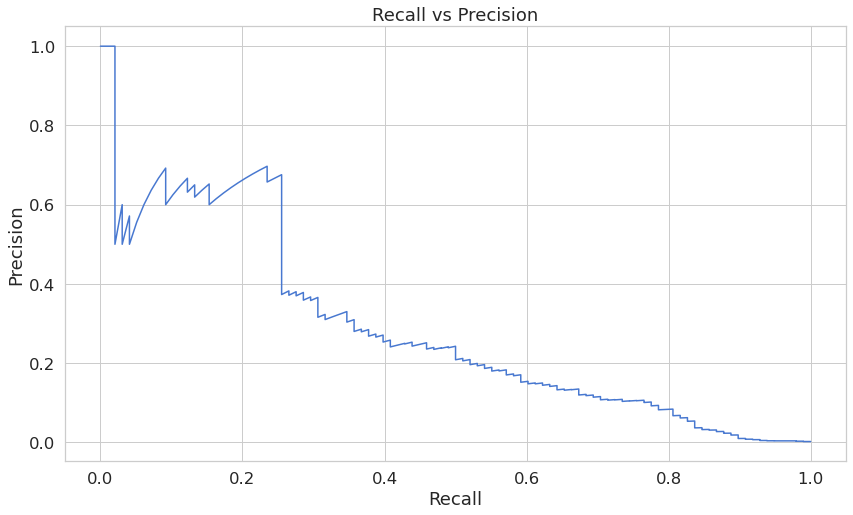

In [21]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

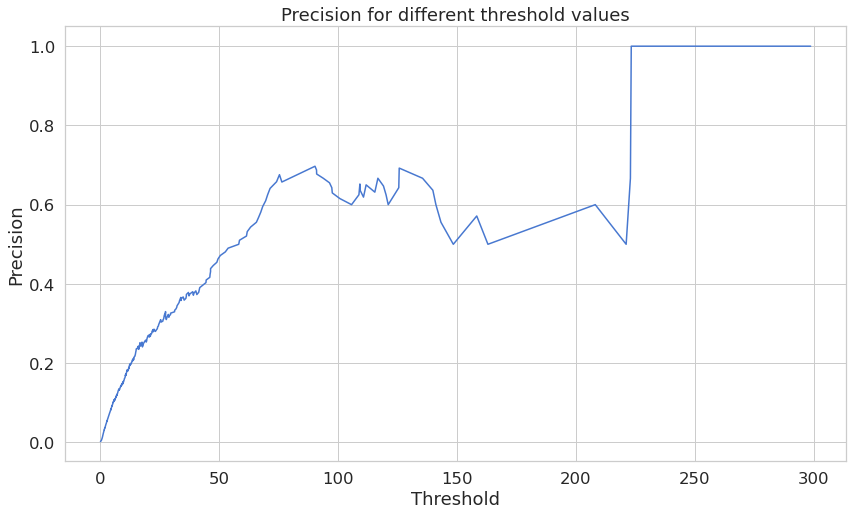

In [22]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

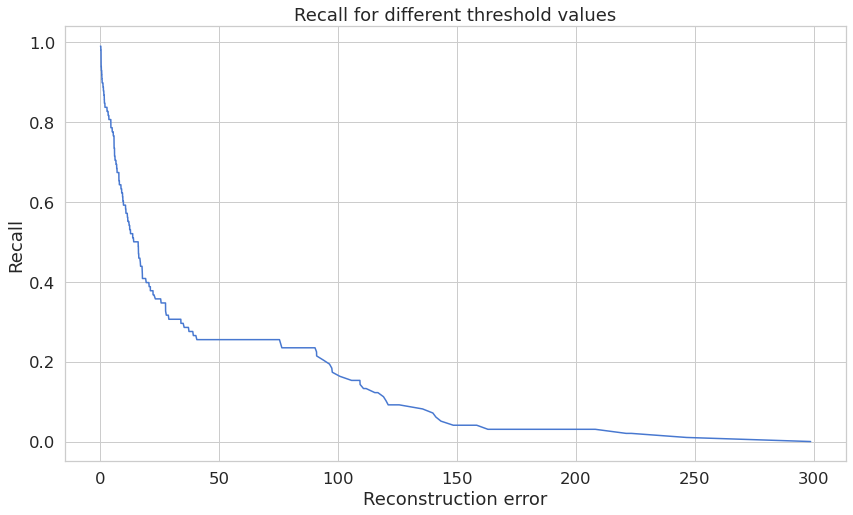

In [23]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [34]:
threshold = 85.0

And see how well we're dividing the two types of transactions:

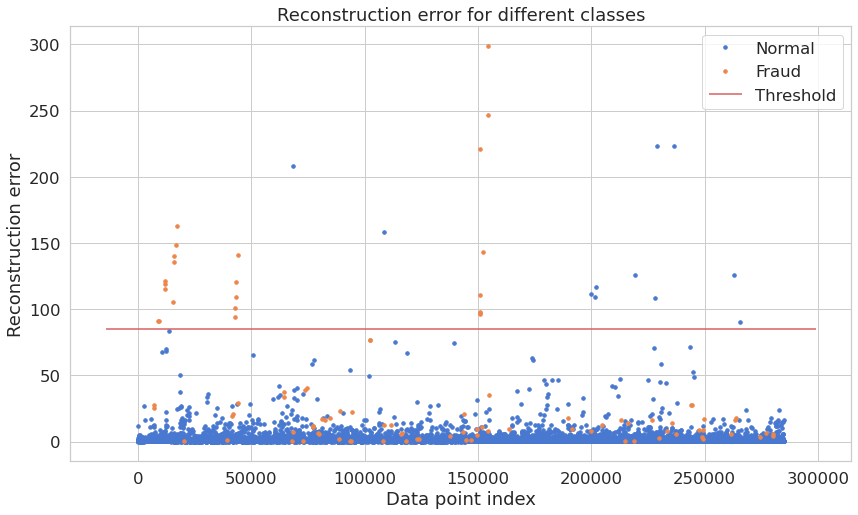

In [35]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Confusion matrix:
[[56853    11]
 [   75    23]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.68      0.23      0.35        98

    accuracy                           1.00     56962
   macro avg       0.84      0.62      0.67     56962
weighted avg       1.00      1.00      1.00     56962



Text(0.5, 1.0, '2-class Precision-Recall curve: AUC=0.16')

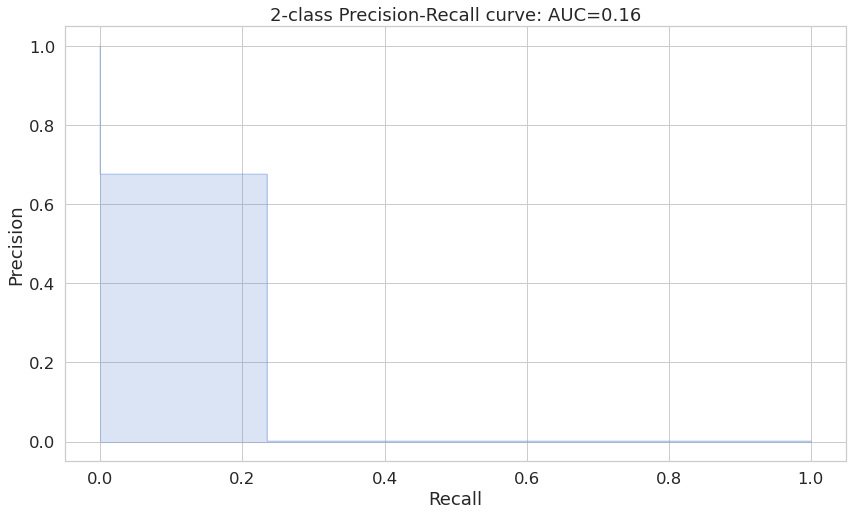

In [36]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % confusion)
print('\n')
print(classification_report(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(average_precision_score(y_test, y_pred)))